# Image Denoising with Autoencoders

## Task 1: Introduction and Importing Libraries
___

In [4]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

For this project, we're using the popular __MNIST__ data set.
This dataset has 60,000 examples of images of handwritten
digits in the training set and 10,000 examples in the test
set. The examples are black and white images of 28 by 28 as
in 28 rows and 28 columns for each example.
The labels are simply digits corresponding to the 10 classes
from 0 to 9.

## Task 2: Data Preprocessing
___


Now we will create two neural network models in this project.
One will be trained to perform classification
of these handwritten digits from the MNIST dataset
and another model will be used to de-noise input data.
And this is our auto encoder.


Eventually, we will connect the two models together and have
them work in conjunction as a single composite model.
In order to input the examples to our models, we will do
a little bit of pre-processing on them.

Basically, we will normalize the values to a range of 0 to 1.
Then, we will reshape the training and tested examples
to 784 dimensional vectors.

In [5]:
# let's load the data and populate these training and test sets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#These will be our numpy arrays.

# Let's normalize the values

# Currently the values are from 0 to 255. They're all integer values for the intensity of our pixels.
# We can change those values and normalize the data by doing the code below.
# We will convert the type of our X_train from integer to a floating point number.
# And then we will divide the result by 255. 
# Now, 255 is the maximum pixel value that we have.
# So this will convert our values and X_train for all
# the pixels to a range of 0 to 1.
X_train = X_train.astype('float') / 255.

# Now we will do the same thing for our test set.
X_test = X_test.astype('float') / 255.

# Re-shape the examples
# We will also reshape our examples from the shape of 28 by 28 to vectors of 784 dimensions.
# And this will make it easy for us to input our examples into the classifier neural network that we'll create.
# We are using the numpy's reshape; and we have 60,000 examples; and the total number of pixels we have are 784.
# This is 28(rows) multiplied by 28(columns).
X_train = np.reshape(X_train, (60000, 784))

# Let's do the same thing for our test set examples.
X_test = np.reshape(X_test, (10000, 784))

Great! Our examples are now ready to be fed into our model. The examples in the MNIST dataset are not noisy, though we
will take a look at some of these images in the task below.

But for our autoencoder, we do want noisy data so that we
can showcase the de-noising example with this method.

## Task 3: Adding Noise
___


In this task, we are artificially adding some noise to our training and test set examples.

Let's create a different variable for this so we can distinguish it from the original data.

In [6]:
# The code below will give us a uniform value between zero and one. 
# We can give it a shape of 60,000 by 784 which is the shape of our X_train.
# Each value here in X_train will have something randomly added to them, 
# and we can scale this down a little bit by multiplying it by 0.9.
X_train_noisy = X_train + np.random.rand(60000, 784) * 0.9

# We can do the same thing for our X_test data
X_test_noisy = X_test + np.random.rand(10000, 784) * 0.9

# ensure that our values remain within the zero and one range that we normally see
# in the previous task.
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

# do the same thing for X_test_noisy
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Note: "0." and "1." simply means that these are going to be floating point values.

That's great! So we added some noise to our data, but we still don't really
know how our data actually looks like. And what happens when we add this noise to that?

So let's take a look.

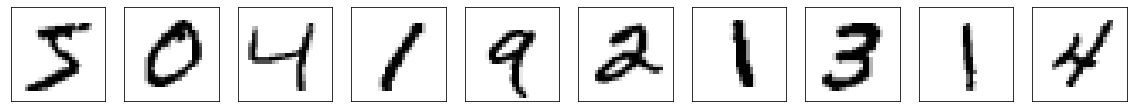

In [26]:
# Create a function that will plot out the first 10 images of any dataset.
# Our function will take a few arguments. It will take "x", "p" and "labels". 
# Labels will be set to false by default.

# normally when we're looking at the data set, we don't want to pass any "p" argument in our function below.
# The "p" here is going to be for prediction, but we're defining it here right now because later we would 
# want to take a look at not just the images, but also their corresponding predictions from our classifier
# and the composite model that we'll create later.

def plot(x, p, labels=False):
    plt.figure(figsize=(20,2))
    for i in range(10): # refers to the first 10 images that we are plotting
        plt.subplot(1, 10, i+1) # 1 row and 10 columns; the index for the subplot 
                                # starts from one rather than from zero. 
                                # So we're adding one here to the index.
        plt.imshow(x[i].reshape(28, 28), # this will show the image except we will have to reshape to 28 by 28 because we flattened it in the previous task.
                   cmap = 'binary') # "binary" so that we see the black and white images as they are.
        # remove the xticks and yticks so set them to blank list
        plt.xticks([])
        plt.yticks([])
        if labels: # if labels is true,
            plt.xlabel(np.argmax(p[i])) # then we also want to label our X axis.
            # This is where the "p" comes in for prediction.
            # If we have predictions on this data set, we will pass those
            # predictions as well. And those predictions will be displayed as 
            # the X labels of the images.
        # Come out of the for loop to display the entire plot.
    plt.show()
    return
# Great! This is our plot function.

# Now let's use it to display the first few images from the X_train data set.
plot(X_train, None) # set "None" for the prediction

So we see a bunch of images displayed in our notebook. Awesome!


Let's use the plot function again. But this time we want to take a look at the noisy examples.
Remember, we just created the X_train_noisy and X_test_noisy and again, we don't have any predictions right now so set it to __None__.

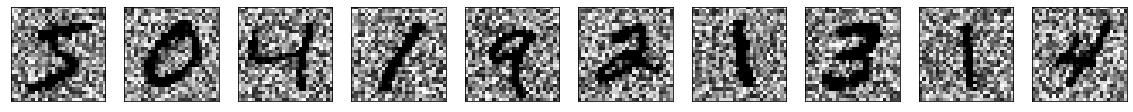

In [27]:
plot(X_train_noisy, None)

These are our same examples, but with some noise added to
them, and that's actually a lot of noise added to them.


So it will be really interesting to check out how a
classifier trained on the non noisy data set would perform on
a noisy data set like this one.

## Task 4: Building and Training a Classifier
___


In this task, we will create a classifier and train it to classify handwritten digit
images from our MNIST dataset. We will use a very straightforward neural network with just
two hidden layers.

In [10]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax') # softmax to get probability score from this model
])

# compile our model
classifier.compile(
    optimizer = 'adam', #short for adaptive moment estimate; works kinda like the RMS prop algorithm but with momentum added to that.
    loss = 'sparse_categorical_crossentropy', # we would have used the categorical crossentropy if our labels 
                                                # were represented in one hot encodings. But they're not. Right now, our labels are not encoded at all.
                                                # They basically just have numeric values for the different classes. So for that reason, 
                                                # we are using sparse, categorical cross entropy
    metrics=['accuracy']
)

# Now we can train our classifier simply by fitting the Model to X_train and y_train.
classifier.fit(X_train, y_train, 
               batch_size=512, # We will also set a batch_size of 512. This is normal, but this is slightly on the higher side.
                                # And we're doing this only to speed up the training.
               epochs=3) # And finally we will set the epochs. We will just train the model for 3 epochs.

Epoch 1/3
118/118 [==============================] - 2s 13ms/step - loss: 0.4255 - accuracy: 0.8853
Epoch 2/3
118/118 [==============================] - 2s 13ms/step - loss: 0.1534 - accuracy: 0.9554
Epoch 3/3
118/118 [==============================] - 1s 12ms/step - loss: 0.1065 - accuracy: 0.9690


I should note that we are training it for just three epochs. And that's mainly because we're not really concerned
about the training accuracy as such. In a state of the art models, of course, you can get, like, 99.6% or something like that. With the MNIST dataset, we are not really concerned about it as long as you get something above 95%, were good.
And you should get that with just three bucks.

Our classifier is trained with the training data set. We can check its performance on the
test data set.

In [11]:
# we'll use our classifier with evaluate function
loss, acc = classifier.evaluate(X_test, y_test)

# print out the the returned accuracy rate.
print(acc)

313/313 [==============================] - 1s 1ms/step - loss: 0.1014 - accuracy: 0.9690
0.968999981880188


We get 97% accuracy, which is pretty good.
And this is similar to what we got on the training data as
well. 


But what we really wanted to see was the accuracy that we
would get on this classifier with the noisy test data.

In [12]:
# let's evaluate again but this time for our noisy data
loss, acc = classifier.evaluate(X_test_noisy, y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 6.1856 - accuracy: 0.2810
0.2809999883174896


We get something like 28%. The classifier doesn't work at all on noisy data.
This is pretty much random guess from the classifier.

So what we want to do now is to create an autoencoder to de-noise our noisy dataset. Then try this
classifiers evaluation again and see what kind of improvement our image denies.

In order to denoise our data, we want to create a model, the auto encoder, which takes
a noisy example as input and the original corresponding
example as the label.

Now, if one or more hidden layers in this neural network has
a lot less nodes compared to the input and output, then
the training process will force the network to learn
a function similar to principal component analysis,
essentially reducing dimensionality.

And it will essentially force the model to learn the more important characteristics from the data set and focus only on that.

## Task 5: Building the Autoencoder
___


Let's build our encoder and decoder.

In [13]:
# One more thing to note here is that the output layer will have a sigmoid activation.
# We are going to use keras's functional api to create this autoencoder.
# Let's create a variable input_image and define with the input layer from Keras, and this
# is of shape 784 dimensional vector.
input_image = Input(shape=(784,))

# Our encoded result is essentially going through a dense layer with reduced dimensionality.
# Create single dense layer passing in the input_image
encoded = Dense(64, activation='relu')(input_image)

# create one also for decoding
# Create single dense layer passing in the encoded
decoded = Dense(784, activation='sigmoid')(encoded)

So we take something that 784 features. We reduce the dimensionality and we force it
to a 64 node fully connected layer.
And then we expand it again back to 784 values.

So with this way, hopefully, our autoencoder, when we train it,
learns to focus only on the important stuff and then is
able to because of that is able to de noise and ignore
the data which is not important.

This is where the sigmoid activation will also come into the picture.
The higher linear values of the last layer will become closer
to the maximum normalized pixel value of one. And the low linear values will converge towards the minimum normalized pixel values of zero.
So this stress of activation makes sense, given the examples,
and then put our black and white images. There is still some scope for having a variety of pixel
values with some linearity in it, because the sigmoid does have a linear part to it as well.
But most values will converge to either zero in one, and that works well for us.

However, this does not give us the ah auto encoder model just yet.
We will need to use the model class from keras to create that.

In [14]:
# Build the Autoencoder.
# our input is going to be input image and output is simply going to be the decoded output.
autoencoder = Model(input_image, decoded)

# We also need to compile it.
# We'll also set the loss because we are using softmax in the final layer.
# Use the optimizer as adam.
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

Now that we have the autoencoder, we'll go to the next task and train this autoencoder.

## Task 6: Training the Autoencoder
___


We will use the noisy training set examples as our examples and the original training set examples, the ones without any noise, will be used as our labels for the autoencoder to learn de-noising. 

The idea being that by doing this training, our autoencoder will learn to recognize the important
features and learn to ignore the rest of the not so important features.

In [16]:
autoencoder.fit(
    X_train_noisy, X_train, 
    epochs=100, # We will use a slightly higher number of epochs this time. 
                # We probably will not have to train 400 epochs because 
                # we're going to use early stopping callback. 
    batch_size=512, # We will set a batch size to 512. 
                    # This is slightly higher than usual, but this will help speed
                    # up the training process.
    validation_split=0.2, # Use a validation split of 20%,
    verbose=False, # set verbose to false because we don't want to actually use any build logs. 
                   # Potentially because we're looking at 100 epochs. 
                   # So we don't want to crowd the notebook too much.
                   # Instead, we will use a Lambda callback for a simple logging.
    # Let us now define our callbacks; use early stopping; use monitor validation loss 
    # and set a patient of 5 epochs.
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
    # So if the validation loss does not improve, as if it does not decrease 
    # for five epochs, then our model will stop the training.
        # We will also use Lambda Callback passing in the "on_epoch_end" pertaining to the end of Epoch.
        # We will use a lambda function; We will print out a validation loss;
        # We will also set the ending of our print statement a blank underscore blank.
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
        # This is so that we don't print the validation loss for every epoch in new line. 
        # It sort of keeps going on and on in a single line until the training is complete.
    ]
)
# When the training is complete, let's print out a statement "Training is complete!"
print(' _ ')
print('Training is complete!')

0.225 _ 0.197 _ 0.180 _ 0.169 _ 0.161 _ 0.153 _ 0.147 _ 0.142 _ 0.138 _ 0.134 _ 0.131 _ 0.128 _ 0.126 _ 0.124 _ 0.122 _ 0.120 _ 0.119 _ 0.117 _ 0.116 _ 0.115 _ 0.115 _ 0.114 _ 0.113 _ 0.113 _ 0.112 _ 0.111 _ 0.111 _ 0.111 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _  _ 
Training is complete!


So now that the auto encoder is trained, let's put it to use.

## Task 7: Denoised Images
___


In order to get our de-noised images, say for our test data, all we have to do is pass the noisy data
through the autoencoder.

In [30]:
# Let's save it in a variable called prediction and use the autoencoders method to 
# get our outputs then we will pass the X_test_noisy data.
predictions = autoencoder.predict(X_test_noisy)

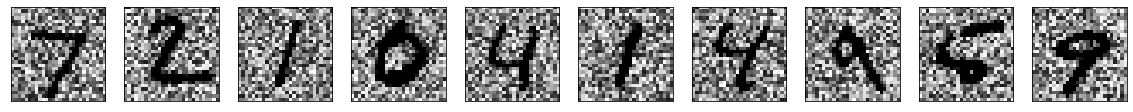

In [31]:
# To make a comparison, let's plot the images first.
plot(X_test_noisy, None)

These are the noisy test images that were denoised.

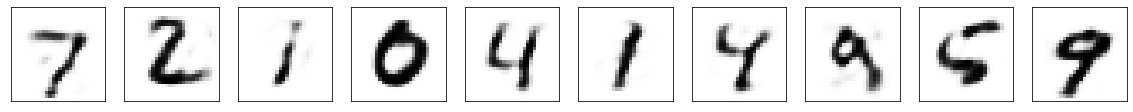

In [32]:
# Let's plot also the denoised output.
plot(predictions, None)

Great! We can see that it has a done a pretty descent job. Of course, there are ways to improve this performance, especially if we use convolutional neural networks and our autoencoder. But this is still pretty good.

Now, while they look good, we also want to check out how they performed after denoising these images with our classifier.

In [20]:
loss, acc = classifier.evaluate(predictions, y_test)
print(acc)

# Remember, we got fairly low accuracy score for the noisy dataset before, around 10%.
# And of course, that score might be different everytime we re-run this model.
# However, after doing the denoizing, this score should improve drastically.

313/313 [==============================] - 1s 2ms/step - loss: 0.1753 - accuracy: 0.9403
0.9402999877929688


Great! Now we get 94% accuracy rate. Again it will be different everytime we re-run this, but it
will be in the ballpark.

So this is a lot of improvement from when we evaluated the noisy test set images with the classifier.
Now we are successfully able to denoise our images to a degree where our classifier is actually able to recognize the digits and the classes in those images.

As one final step, we will now hook up our classifier and the auto encoder to create one composite model
and basically complete our entire pipeline.

## Task 8: Composite Model
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

Let's create our composite model to complete our entire
prediction pipeline. We want a model in which we can simply
feed a noisy image, or it could be a non noisy image
and the model will first denoise that and then use the denoised image and run
it through the classifier to get the class prediction. The idea
being that even if our incoming data in a production setting
is noisy, our classifier should be able to work well
because of the denoizing from the autoenoder.

This is a useful idea in a lot of production settings.

So, just like before, we will use keras functional API
to do this.

In [22]:
input_image = Input(shape=(784,))
x  =autoencoder(input_image)
y = classifier(x)

# Now we need to encapsulate this within a model. So we will use the model class 
# from Keras's functional API.
denoised_and_classify = Model(input_image, y)

Now let's put it to work.  
Let's get some predictions and let's use the noisy test set.

In [33]:
predictions = denoised_and_classify.predict(X_test_noisy)

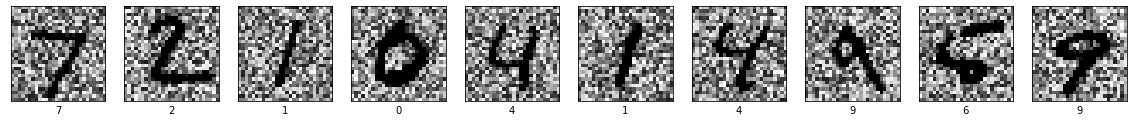

In [34]:
# Let's plot out the X_test image data and the predictions.
plot(X_test_noisy, predictions, True)

# And this time we want to show the labels.
# So we set the labels to true and give predictions instead
# of none that we've been doing so far.
# This time we want to label the images as well.

All right! So we can see the labelling is actually now pretty good.
Although the number "6" is mislabeled, but other than that, everything else is correct.

And if we want just to make sure, we can make a comparison with the original labels

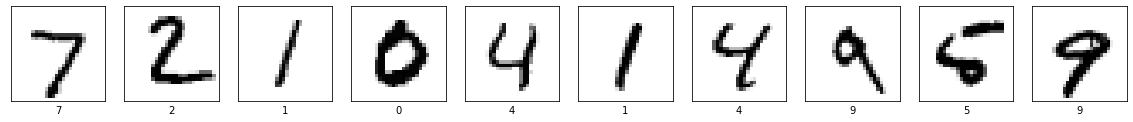

In [35]:
# Except I am doing a one hot encoding on the y_test, so that they are in the format 
# that a plot function expect and set the prediction story labels to true.
plot(X_test, to_categorical(y_test), True)

Great! So, apart from the number "5", which seems, not correctly
identified by our denoise and classifier model, everything
else is actually correct.